In [1]:
import os
import sys
import time
import errno
import time
import timeit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
cwd = os.getcwd()
cwd

'/data/TimeSeriesForcasting'

In [4]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer

from keras.layers import Input
from keras.models import Model

from keras import callbacks, optimizers

import tensorflow as tf
import tensorflow_probability as tfp


class DenseVariational(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.init_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)

        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))


# data

In [5]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

In [6]:
data_size = 30
noise = 1.

X = np.linspace(-0.5, 0.5, data_size).reshape(-1, 1)
Y = f(X, sigma=noise)
Y_true = f(X, sigma=0.0)

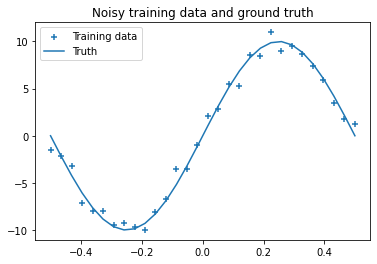

In [7]:
plt.scatter(X, Y, marker='+', label='Training data')
plt.plot(X, Y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [8]:
train_size=len(Y)
train_size

30

In [9]:
batch_size = train_size
num_batches = train_size / batch_size

kl_weight = 1.0 / num_batches
prior_params = {
    'prior_sigma_1': 1.5, 
    'prior_sigma_2': 0.1, 
    'prior_pi': 0.5 
}

x_in = Input(shape=(1,))
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(1, kl_weight, **prior_params)(x)

model = Model(x_in, x)

In [10]:
def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

In [15]:
start_time = time.time()

model.compile(loss=neg_log_likelihood, optimizer=tf.optimizers.Adam(lr=0.01), metrics=['mse'])
model.fit(X, Y, batch_size=batch_size, epochs=1500, verbose=0);

print("--- training took: %s seconds ---" % (time.time() - start_time))    

--- training took: 8.827615022659302 seconds ---


In [16]:
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
Y_pred_list = []

for i in tqdm.tqdm(range(1000)):
    Y_pred = model.predict(X_test)
    Y_pred_list.append(Y_pred)
    

100%|██████████| 1000/1000 [03:25<00:00,  4.87it/s]


In [17]:
Y_preds = np.concatenate(Y_pred_list, axis=1)

Y_mean = np.mean(Y_preds, axis=1)
Y_sigma = np.std(Y_preds, axis=1)

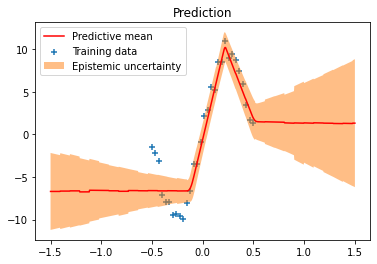

In [18]:
plt.plot(X_test, Y_mean, 'r-', label='Predictive mean');
plt.scatter(X, Y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 Y_mean + 2 * Y_sigma, 
                 Y_mean - 2 * Y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend();